In [107]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from math import log, floor, sqrt


colormap = mpl.cm.copper 
norm = mpl.colors.Normalize(vmin=5, vmax=95)


In [118]:

def cost_per_model(pct, algo='svm'): 
    x = [i for i in range(1,101, 1)] 
 
    if algo == 'rf': 
        nlogn = [i*log(i) for i in x]
        return nlogn[99]/nlogn[int(pct*100) - 1]
    if algo == 'svm':
        n_n = [i*i for i in x]
        return n_n[99]/n_n[int(pct*100) - 1] 
    


def budget_division(budget, how='equal', steps=3, lower=0.4):
    
    def normalize_budget(arr, budget):
        '''sum(arr).X = budget'''
        return budget / sum(arr)
    
    if how == 'equal':
        return [int(budget/steps) for _ in range(steps)]
    else:
        slices = [budget/(1+s) for s in range(steps)]
        norm_factor = normalize_budget(slices, budget)
        normalized_slices = [norm_factor*s for s in slices]
        
        if how == 'linear_asc':
            return normalized_slices
        if how == 'linear_desc':
            return normalized_slices[::-1]
        

def models_at_sample_size(budget, sample_size, algo):
    return int(budget*cost_per_model(sample_size, algo))


def size(i, lower=0.4, steps=3):
    #i += 1
    return lower + i * (1 - lower)/(steps - 1)


In [119]:
def get_data():
    """Synthetic binary classification dataset."""
    data, targets = make_classification(
        n_samples=2_000,
        n_features=22,
        n_informative=12,
        n_redundant=4, 
        random_state=0,
    )
    return data, targets

In [120]:
#def rfc_cv(n_estimators, min_samples_split, max_features, data, targets): 
def rfc_cv(n_estimators, min_samples_split, data, targets):  
    
    estimator = RFC(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        #max_features=max_features,
        random_state=2
    ) 
    
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_log_loss', cv=4)
    return cval.mean()
 

def optimize_rfc(data, targets, level, n_iter=10, bounds=None, probe=None):
    """Apply Bayesian Optimization to Random Forest parameters."""
    #def rfc_crossval(n_estimators, min_samples_split, max_features): 
    def rfc_crossval(n_estimators, min_samples_split): 
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            #max_features=max(min(max_features, 0.999), 1e-3), 
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 150),
            "min_samples_split": (2, 25),
            #"max_features": (0.1, 0.999), 
        },
        random_state=1234,
        verbose=2
    ) 
    
    if len(params) > 0:
        for p in params: 
            optimizer.probe(
            params=p,
            lazy=True,
            )
    
    
    optimizer.maximize(init_points=2, n_iter=n_iter, acq="ucb", kappa=10/level) 
    
    x0_obs = np.array([[res["params"]["min_samples_split"]] for res in optimizer.res])
    x1_obs = np.array([[res["params"]["n_estimators"]] for res in optimizer.res]) 
    y_obs = np.array([res["target"] for res in optimizer.res]) 
    
    #plt.scatter(x_obs, y_obs, c=colorst[len(x_obs)])
    #plt.scatter(x0_obs, x1_obs, 'x', label=str(len(x0_obs)))     
    plt.scatter(x0_obs, x1_obs, label=str(len(x0_obs)))     
    
    n_points = floor(sqrt(n_iter))
    idx = y_obs.argsort()[-n_points:][::-1]
    to_explore = [[x0_obs[i], x1_obs[i]] for i in idx]   
    return to_explore



## Case 1:  
Budget: 100  
Equally divided in 3 steps: 0.4, 0.7, 1  

--- Optimizing Random Forest: 17 models; budget:5.454545454545455 --- 
|   iter    |  target   | min_sa... | n_esti... |
-------------------------------------------------
|  1        | -0.4356   |  6.405    |  97.1     |
|  2        | -0.4492   |  12.07    |  120.0    |
|  3        | -0.4357   |  6.427    |  99.31    |
|  4        | -0.4742   |  24.49    |  61.41    |
|  5        | -0.5298   |  2.0      |  10.0     |
|  6        | -0.4283   |  2.0      |  150.0    |
|  7        | -0.4789   |  25.0     |  150.0    |
|  8        | -0.4325   |  2.0      |  53.48    |
|  9        | -0.4815   |  25.0     |  30.82    |
|  10       | -0.4778   |  25.0     |  96.8     |
|  11       | -0.4302   |  2.0      |  73.45    |
|  12       | -0.4285   |  2.0      |  131.6    |
|  13       | -0.4931   |  25.0     |  10.0     |
|  14       | -0.4357   |  2.0      |  35.61    |
|  15       | -0.4781   |  25.0     |  129.6    |
|  16       | -0.4626   |  18.5     |  78.73    |
|  17       | -0.4285   |  2.

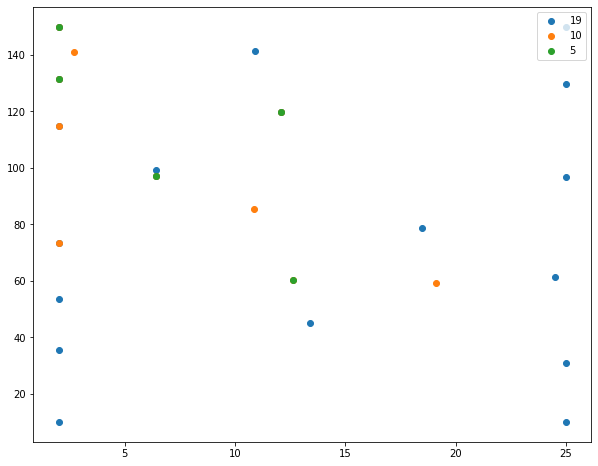

In [123]:
data, targets = get_data() 

level = 1
lower = 0.4
steps = 3
budget = 10

bounds = None
params = []

plt.figure(figsize=(10,8))
for i, b in enumerate(budget_division(budget, how='linear_asc', steps=steps, lower=lower)):
    sample_size = size(i, lower, steps) 
    n_iter = models_at_sample_size(b, sample_size, 'rf')
    
    rows = int(len(data) * sample_size)
    idx = np.random.choice(len(data), rows, replace=False) 
    sampled_X = data[idx,:]
    sampled_y = targets[idx]
    data, targets = get_data() 

    print(Colours.green(f"--- Optimizing Random Forest: {n_iter} models; budget:{b} --- "))
    params = optimize_rfc(sampled_X, sampled_y, level, n_iter, bounds, params)   
    level += 1
plt.legend(loc="upper right")